!!먼저 구글 드라이브에 EEL이라는 폴더 생성후 dataset.zip 을 해당 폴더에 업로드 한 후 실행이 가능합니다!!

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/MyDrive/EEL

/content/gdrive/MyDrive/EEL


In [ ]:
!unzip /content/gdrive/MyDrive/EEL/dataset.zip

Archive:  /content/gdrive/MyDrive/EEL/dataset.zip


In [4]:
!ls

dataset		  eel	      input.jpg		test_avg.json
dataset.zip	  eelproject  output		train_avg.json
detectron2.ipynb  filtered    preprocess.ipynb


In [68]:
import posixpath
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from functools import lru_cache
import os
import cv2
import scipy.fftpack
import openpyxl
from google.colab.patches import cv2_imshow
import json as js
__train_csv = pd.read_csv("./dataset/train.csv")
__test = os.path.join(os.getcwd(), "dataset/test")
__train_csv_col = []
__test_list = sorted(os.listdir(__test))
__test_data_list = [sorted(os.listdir(os.path.join(__test, __test_list[test_idx]))) for test_idx in range(len(__test_list))]

for col in __train_csv.columns:
    __train_csv_col.append(col)

@lru_cache()
def get_test_len():
    return len(__test_list)

def _write_test_list_on_xlsv(epoch):
    PATH = f'./submission{epoch}.xlsx'
    if os.path.isfile(PATH) and os.access(PATH, os.R_OK):
        pass
    else:
        wb = openpyxl.Workbook()
        wb.save(PATH)
    xfile = openpyxl.load_workbook(PATH)
    sheet = xfile['Sheet']
    sheet["A1"] = "ImageDir"
    sheet["B1"] = "AvgWeight"
    
    for i in range(2, get_test_len() + 2):
        cell = "A" + str(i)
        sheet[cell] = __test_list[i-2]
    xfile.save(PATH)

def write_prediction_on_row(epoch, foldername, avg):
    PATH = f'./submission{epoch}.xlsx'
    if os.path.isfile(PATH) and os.access(PATH, os.R_OK):
        pass
    else:
        _write_test_list_on_xlsv(epoch)
    xfile = openpyxl.load_workbook(PATH)
    sheet = xfile['Sheet']
    done=False
    for i in range(2, get_test_len() + 2):
        cell = "A" + str(i)
        # print(sheet[cell].value)
        if sheet[cell].value == foldername:
            cell2 = "B" + str(i)
            sheet[cell2].value = avg
            done = True
            break
    if done == False:
        raise IOError("wrong foldername")
    xfile.save(PATH)

@lru_cache(maxsize=None)
def get_test_data_len(idx):
    return len(__test_data_list[idx])//2

@lru_cache(maxsize=None)
def get_test_data(idx, dataidx):
    if idx < 0:
        idx = len(__test_list) + idx
    if idx < 0 or idx >= len(__test_list):
        raise ValueError("test row index out of range")
    filelist = __test_data_list[idx]
    filelist.sort()
    if dataidx < 0:
        dataidx = len(filelist)//2 + dataidx
    if dataidx < 0 or dataidx >= len(filelist)//2:
        raise ValueError("data file index out of range")
    jpgpath = "./dataset/test/" + __test_list[idx] + "/" + filelist[dataidx*2]
    jsonpath = "./dataset/test/" + __test_list[idx] + "/" + filelist[(dataidx * 2 + 1)]
    jpg = cv2.imread(jpgpath, flags=cv2.IMREAD_GRAYSCALE)
    with open(jsonpath, encoding="UTF-8") as jsonf:
        json = js.load(jsonf)
        return jpg, json


@lru_cache(maxsize=None)
def get_row_csv(idx):
    if idx < 0:
        idx = len(__train_csv) + idx
    if idx < 0 or idx >= len(__train_csv):
        raise ValueError("csv row index out of range")
    return __train_csv['ImageDir'][idx], __train_csv['AvgWeight'][idx]


@lru_cache()
def get_row_len():
    return len(__train_csv)


@lru_cache(maxsize=None)
def get_train_list(idx):
    if idx < 0:
        idx = len(__train_csv) + idx
    if idx < 0 or idx >= len(__train_csv):
        raise ValueError("csv row index out of range")
    curpath = "./dataset/train/" + get_row_csv(idx)[0]
    files = os.listdir(curpath)

    return files


@lru_cache()
def get_data_len(idx):
    if idx < 0:
        idx = len(__train_csv) + idx
    if idx < 0 or idx >= len(__train_csv):
        raise ValueError("csv row index out of range")
    return len(get_train_list(idx)) // 2


@lru_cache(maxsize=None)
def get_train_data(idx, dataidx):
    if idx < 0:
        idx = len(__train_csv) + idx
    if idx < 0 or idx >= len(__train_csv):
        raise ValueError("csv row index out of range")
    filelist = get_train_list(idx)
    filelist.sort()
    if dataidx < 0:
        dataidx = len(filelist)//2 + dataidx
    if dataidx < 0 or dataidx >= len(filelist)//2:
        raise ValueError("data file index out of range")
    jpgpath = "./dataset/train/" + get_row_csv(idx)[0] + "/" + filelist[(dataidx * 2)]
    jsonpath = "./dataset/train/" + get_row_csv(idx)[0] + "/" + filelist[(dataidx * 2 + 1)]
    jpg = cv2.imread(jpgpath, flags=cv2.IMREAD_GRAYSCALE)
    with open(jsonpath, encoding="UTF-8") as jsonf:
        json = js.load(jsonf)
        return jpg, json


def show_jpg(jpg, windowname=None):
    if windowname is None:
        windowname = ''
    cv2_imshow(windowname, jpg)
    # cv2.waitKey(0)

def show_polygons(idx, dataidx):
    jpg, json = get_train_data(idx, dataidx)
    polylist = json["data"]
    for polygon in polylist:
        corlist = np.column_stack((polygon["x"], polygon["y"]))
        cv2.polylines(jpg, np.int32([corlist]), isClosed=True, color=255, thickness=2)
    dim = (1200, int(jpg.shape[0] * 1200/float(jpg.shape[1])))
    cv2_imshow('', cv2.resize(jpg, dim, interpolation=cv2.INTER_AREA))
    # cv2.waitKey(0)


def show_all_polygons():

    for idx in range(get_row_len()):
        for dataidx in range(get_data_len(idx)):

            show_polygons(idx, dataidx)


def edge_detect(idx, dataidx):
    jpg, json = get_train_data(idx, dataidx)
    print(jpg)
    print(jpg.shape)
    edge1 = cv2.Canny(jpg, 45, 50)
    edge2 = cv2.Canny(jpg, 45, 60)
    edge3 = cv2.Canny(jpg, 60, 70)
    dim = (1200*3, int(jpg.shape[0] * 1200/float(jpg.shape[1])))
    hori = np.concatenate((edge1, edge2, edge3), axis=1)
    cv2_imshow('', cv2.resize(hori, dim, interpolation=cv2.INTER_AREA))
    cv2.waitKey(0)
    for perc in range(5, 100, 5):
        print(f"{perc}th percentile: {np.percentile(jpg, perc)}")

    plt.hist(jpg, bins=10)
    plt.show()

@lru_cache(maxsize=None)
def calc_polygon_area(idx, dataidx):
    _, json = get_train_data(idx, dataidx)
    polylist = json["data"]
    s = 0
    for polygon in polylist:
        corlist = np.column_stack((polygon["x"], polygon["y"]))
        s += cv2.contourArea(np.int32([corlist]))
    return s, len(polylist)

@lru_cache(maxsize=None)
def average_polygon_area(idx):
    s = 0
    cnt = 0
    for dataidx in range(get_data_len(idx)):
        ds, dl = calc_polygon_area(idx, dataidx)
        s += ds
        cnt += dl
    return s / cnt

@lru_cache(maxsize=None)
def plot_avgarea_avgweight():
    avgarea = np.array([average_polygon_area(idx) for idx in range(get_row_len())])
    avgweight = np.array([get_row_csv(idx)[1] for idx in range(get_row_len())])
    plt.scatter(avgarea, avgweight)
    plt.show()

@lru_cache(maxsize=None)
def plot_normalized_avgarea_avgweight():
    avgarea = np.array([(math.sqrt(average_polygon_area(idx))) ** 3 for idx in range(get_row_len())])
    avgweight = np.array([get_row_csv(idx)[1] for idx in range(get_row_len())])
    plt.scatter(avgarea, avgweight)
    plt.show()

@lru_cache(maxsize=None)
def hcg(idx, dataidx, isTest=False):
    img = None
    if isTest == True:
        img, _ = get_test_data(idx, dataidx)
    else:
        img, _ = get_train_data(idx, dataidx)
    kernel = np.ones((8,8), np.float32)/64
    img = cv2.filter2D(img, -1, kernel)
    rows = img.shape[0]
    cols = img.shape[1]
    imglog = np.log1p(np.array(img, dtype="float") / 255)
    m = 2*rows + 1
    n = 2*cols + 1
    sigma = 10
    (X, Y) = np.meshgrid(np.linspace(0, n-1, n), np.linspace(0, m-1, m))
    centerx = np.ceil(n/2)
    centery = np.ceil(m/2)
    gaussiannumerator = (X - centerx)**2 + (Y - centery)**2
    hlow = np.exp(-gaussiannumerator / (2*sigma*sigma))
    hhigh = 1 - hlow
    hlowshift = scipy.fftpack.ifftshift(hlow.copy())
    hhighshift = scipy.fftpack.ifftshift(hhigh.copy())
    imgf = scipy.fftpack.fft2(imglog.copy(), (m, n))
    ioutlow = np.real(scipy.fftpack.ifft2(imgf.copy() * hlowshift, (m, n)))
    iouthigh = np.real(scipy.fftpack.ifft2(imgf.copy() * hhighshift, (m, n)))
    gamma1 = 0.3
    gamma2 = 1.5
    iout = gamma1*ioutlow[0:rows, 0:cols] + gamma2*iouthigh[0:rows, 0:cols]
    ihmf = np.expm1(iout)
    ihmf = (ihmf - np.min(ihmf)) / (np.max(ihmf) - np.min(ihmf))
    ihmf = np.array(255*ihmf, dtype="uint8")
    return ihmf


def save_filtered_train():
    for i in range(get_row_len()):
        for j in range(get_data_len(i)):
            filename = f"{i}_{j}_filtered.jpg"
            path = os.path.join(os.getcwd(), 'filtered', 'train', get_row_csv[i])
            os.makedirs(path, exist_ok=True)
            path = os.path.join(path, filename)
            cv2.imwrite(path, hcg(i, j))
            print(f"Done {i} {j}")

def save_filtered_test():
    for i in range(get_test_len()):
        for j in range(get_test_data_len(i)):
            filename = f"{i}_{j}_filtered_test.jpg"
            path = os.path.join(os.getcwd(), 'filtered', 'test', __test_list[i])
            os.makedirs(path, exist_ok=True)
            path = os.path.join(path, filename)
            cv2.imwrite(path, hcg(i, j, isTest=True))
            print(f"Done {i} {j}")

In [53]:
if __name__ == "__main__":
    save_filtered_train()
    save_filtered_test()


KeyboardInterrupt



train 251.86700000000008 242.39999999999998

In [54]:
filtered_train = sorted([_ for _ in os.listdir("filtered/train")])
filtered_test = sorted([_ for _ in os.listdir("filtered/test")])
print(filtered_train)
print(filtered_test)

os.makedirs("eel/train", exist_ok=True)
os.makedirs("eel/val", exist_ok=True)

# img=cv2.imread("filtered/test/1I2EkxetCZ/0_0_filtered_test.jpg")
# cv2_imshow(img)
# cv2.waitKey(0)

['09xhTGOWvG', '1IfHWGbtMf', '2FINMdB8FA', '2ZUn5NjsOy', '2io6VOZw5l', '35Nnt2j9IH', '3Qx3IAKZko', '3zdESgH6pI', '4GY08vDuPn', '5MFsHl7Uei', '5ofA75UyiC', '658R6rCHZt', '66nVberACp', '69Z7zrpEFi', '6Fq5axtjRN', '6T2bwGfcCv', '6hVVXk07zi', '6mMkgGYau5', '78QitWQ2V6', '7n1AyOHFRu', '8HGNWkz2YS', '8iZZyHYHXr', '9IObHxTaZh', '9QtvnQzKlI', '9Y1hPCa3yT', '9cbMOeEeUt', 'A7A6jpVkOy', 'B18AIYTimz', 'B7GiPnXj0S', 'C3J27XDCG2', 'C84FL8SfWo', 'CHJs1UJOkH', 'D5utuFj7XX', 'DcjHyhKzlv', 'Duoz97U5Hp', 'EhG5tYGN2w', 'EwA5N6SKWA', 'G16JqtQy92', 'G9qpVTzqA0', 'GNqTmSH4Bb', 'HiqpK7vdPY', 'ITclorXwIS', 'IfvfrVg5uf', 'JAXrF6bnZ3', 'JNG5KEjmlh', 'JX9fE3ozdn', 'KIIJeJ6qk6', 'KKF0RDt0Xa', 'KMmGLvZWqr', 'KbhNgVpqCz', 'LKllfWD42s', 'LmlZGEONYl', 'MbXDuCL1mH', 'Na1Hedcm4p', 'NcgoIreWf6', 'ORZbgmKRw6', 'RkJpOxEEwn', 'RkunyBHsr4', 'T11NCue1cr', 'TEpsKhDXa2', 'Te8r0khCEr', 'UWSus4jowQ', 'Uvy7VSLDCD', 'VqyZjxjP1M', 'W9cy78kyEk', 'XpLcOkAWRy', 'YdQ7p5a3E5', 'ZUeTN6cAW0', 'ZboHdIkKs9', 'a4wO5Ndor8', 'aMeffOhq4A', 'bOPj

In [55]:
c=0

for trdir in filtered_train:
    for fname in os.listdir(f"filtered/train/{trdir}"):
        idx = fname.split("_")[1]
        if c % 10 != 9:
            cv2.imwrite(f"eel/train/{trdir}_{idx}.jpg", cv2.imread(f"filtered/train/{trdir}/{fname}"))
        else:
            cv2.imwrite(f"eel/val/{trdir}_{idx}.jpg", cv2.imread(f"filtered/train/{trdir}/{fname}"))
        c+=1

for tsdir in filtered_test:
    for fname in os.listdir(f"filtered/test/{tsdir}"):
        idx = fname.split("_")[1]
        if c % 10 != 9:
            cv2.imwrite(f"eel/train/{tsdir}_{idx}.jpg", cv2.imread(f"filtered/test/{tsdir}/{fname}"))
        else:
            cv2.imwrite(f"eel/val/{tsdir}_{idx}.jpg", cv2.imread(f"filtered/test/{tsdir}/{fname}"))
        c+=1

KeyboardInterrupt: ignored

In [ ]:
for tag in ["train", "val"]:
    dic={}
    c=0
    flist = sorted(os.listdir(f"eel/{tag}"))
    print(flist)
    for f in flist:
        c+=1
        d = {}
        d["fileref"] = ""
        d["size"]=100000
        d["filename"] = f
        d["base64_img_data"]=""
        d["file_attributes"]={}
        r = {}
        d["regions"] = r
        dic[str(c)] = d
        lst = (f.split(".")[0]).split("_")
        dirname = lst[0]
        idx = lst[1]
        if os.path.isdir(f"dataset/train/{dirname}/"):
            s = str(int(idx))
            jsonname = "0"*(5 - len(s)) + s
            with open(f"dataset/train/{dirname}/{jsonname}.json", "r") as jsfile:
                json = js.load(jsfile)
                for polyid, poly in enumerate(json["data"]):
                    pdict = {}
                    r[str(polyid)]=pdict
                    pdict["name"]="polygon"
                    pdict["region_attributes"]={}
                    pdict["all_points_x"]=[]
                    pdict["all_points_y"]=[]
                    for x in poly["x"]:
                        pdict["all_points_x"].append(float(x))
                    for y in poly["y"]:
                        pdict["all_points_y"].append(float(y))
        else:
            s = str(int(idx))
            jsonname = "0"*(5 - len(s)) + s
            with open(f"dataset/test/{dirname}/{jsonname}.json", "r") as jsfile:
                json = js.load(jsfile)
                for polyid, poly in enumerate(json["data"]):
                    pdict = {}
                    r[str(polyid)]=pdict
                    pdict["name"]="polygon"
                    pdict["region_attributes"]={}
                    pdict["all_points_x"]=[]
                    pdict["all_points_y"]=[]
                    for x in poly["x"]:
                        pdict["all_points_x"].append(float(x))
                    for y in poly["y"]:
                        pdict["all_points_y"].append(float(y))
    with open(f"eel/{tag}/via_region_data.json", "w") as writejs:
        js.dump(dic, writejs)

regression

In [56]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
train_csv = pd.read_csv("dataset/train.csv")
x = []
y = []
z = []
with open("train_avg.json", "r") as f:
    d = json.load(f)
    for i, j in d.items():
        zval = train_csv['AvgWeight'][list(train_csv['ImageDir']).index(i)]
        c = 0
        s = 0
        for a, b in j.items():
            c += 1
            s += b
        area = s/c

        x.append(area)
        y.append(c)
        z.append(zval)
# plt.scatter(x, z)
# plt.show()



# load some test data for demonstration and plot a wireframe
x=np.array(x)
y=np.array(y)
z=np.array(z)
df = pd.DataFrame(x)
df = pd.DataFrame(pd.np.column_stack([df, y]))
df = pd.DataFrame(pd.np.column_stack([df, z]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


In [57]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop(2)
test_labels = test_features.pop(2)

train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
0,562.532668,205.730658
1,93.767677,17.803249
2,49.376380,27.261126


In [58]:
import tensorflow as tf

In [59]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[562.5326   93.76768]]


In [60]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[482.22 102.  ]]

Normalized: [[-0.39  0.46]]


In [61]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.3),
      layers.BatchNormalization(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.3),
      layers.BatchNormalization(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.3),
      layers.BatchNormalization(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.3),
      layers.BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [62]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 2)                5         
 ion)                                                            
                                                                 
 dense_8 (Dense)             (None, 256)               768       
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [63]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 6.35 s, sys: 747 ms, total: 7.1 s
Wall time: 5 s


In [64]:
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)

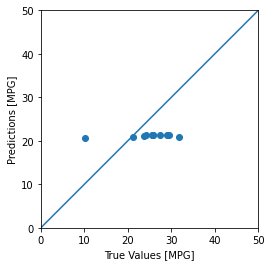

In [65]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [66]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
train_csv = pd.read_csv("dataset/train.csv")
x = []
y = []
z = []
dirlist=[]
with open("test_avg.json", "r") as f:
    d = json.load(f)
    for i, j in d.items():
        # zval = train_csv['AvgWeight'][list(train_csv['ImageDir']).index(i)]
        c = 0
        s = 0
        for a, b in j.items():
            c += 1
            s += b
        area = s/c
        dirlist.append(i)
        x.append(area)
        y.append(c)
        # z.append(zval)
# plt.scatter(x, z)
# plt.show()

print(len(dirlist))

# load some test data for demonstration and plot a wireframe
x=np.array(x)
y=np.array(y)
# z=np.array(z)
df = pd.DataFrame(x)
df = pd.DataFrame(pd.np.column_stack([df, y]))
print(df.shape)
testset= df
normalizer.adapt(np.array(testset))
test_predictions = dnn_model.predict(testset).flatten()
print(test_predictions.shape, test_predictions)

85
(85, 2)
(85,) [24.972704 56.22052  21.289516 21.32005  21.274992 20.883488 20.569939
 72.249275 21.079977 78.85311  21.322157 75.62501  21.300589 67.39702
 56.51788  57.962597 76.566216 77.7704   21.776087 21.035189 27.166086
 21.007032 24.219578 61.098206 21.322649 21.293032 21.294085 69.03582
 63.134537 20.693604 20.692244 76.66939  73.4611   21.064684 59.82497
 24.865702 70.37257  21.32327  51.248447 21.115702 76.06097  24.726835
 25.078268 20.513636 69.92276  21.07428  64.19977  77.554344 64.712036
 79.19941  21.254732 21.138872 21.052565 21.306028 20.947681 21.318174
 20.814594 20.604458 21.310804 46.338085 71.56865  21.168507 73.145035
 27.166088 20.526627 34.605392 35.39215  20.811861 70.91661  58.684345
 21.22309  21.31699  79.21606  25.468605 21.085047 22.958048 65.27717
 22.69443  20.811104 21.293541 21.21352  22.958048 73.651474 80.68416
 70.59676 ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


In [71]:
for i,dirn in enumerate(dirlist):
    try:
        write_prediction_on_row(0, dirn, float(test_predictions[i]))
    except IOError:
        print(dirn)

In [77]:
xlsx = openpyxl.load_workbook("submission0.xlsx")
sheet = xlsx.active
data = sheet.rows
with open("submission.csv", "w") as csvfile:
    for row in data:
        lst = list(row)
        csvfile.write(f"{lst[0].value}, {lst[1].value}\n")
